<h1>Fruiteasy  : Enlightening Choices for Healthier Living through an Image Classification Approach for Improved Nutritional Awareness</h1>

## Dependencies (RUN ME)

In [1]:
%config Completer.use_jedi= False
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import zipfile

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

In [2]:
print(tf.__version__)
print(np.__version__)

2.15.0
1.25.2


# A. Train the model

## 1. Get Dataset

In [8]:
#@markdown ## Get the dataset link ID from URL in <a href="https://github.com/yanuarcy/Fruiteasy/blob/ML/Assets/dataset-and-pretrain.txt">Here</a>

#@markdown ___

#@markdown Format:

#@markdown ``https://drive.google.com/file/d/1bnnz-AsxpF74U6WouIYl70Nb-nrVr4Io/view?usp=sharing`` ❌

#@markdown ``1bnnz-AsxpF74U6WouIYl70Nb-nrVr4Io`` ✔️

# download dataset complete(V4)
DATASET_URL = '1bnnz-AsxpF74U6WouIYl70Nb-nrVr4Io' #@param {type:"string"}
!gdown --id {DATASET_URL}

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1bnnz-AsxpF74U6WouIYl70Nb-nrVr4Io
From (redirected): https://drive.google.com/uc?id=1bnnz-AsxpF74U6WouIYl70Nb-nrVr4Io&confirm=t&uuid=7895dbf5-54b9-4e14-ab52-2fb9ca7c2d20
To: /content/Complete-ready-to-useV4.zip
100% 99.3M/99.3M [00:00<00:00, 213MB/s]


In [9]:
import zipfile

#@markdown Copy the zip dataset path from the files

#directories extract destination
destination_dir='./dataset'
#zip location
zip_dir='/content/Complete-ready-to-useV4.zip' #@param {type:"string"}

# Extract the zip file
with zipfile.ZipFile(zip_dir, 'r') as zip_ref:
    zip_ref.extractall(destination_dir)

In [10]:
#@markdown Insert the dataset name without ``.zip``

#sanity check for extracted dataset
dataset_name = 'Complete-ready-to-useV4' #@param {type:"string"}
new_destination=f"{os.path.join(destination_dir, dataset_name)}"
classes=os.listdir(new_destination)

def countDatainPath(path):
    dataX=np.zeros(len(os.listdir(path)))
    classes=os.listdir(path)

    #iterate for each class and find length of data
    for i,class_dir in enumerate(classes):
        source_class_dir=os.path.join(path,class_dir)
        dataX[i]=int(len(os.listdir(source_class_dir)))
        # print(dataX[i])
    return [dataX,classes]

source_data_images_dir=f"{new_destination}"
[dataX,dataY]=countDatainPath(source_data_images_dir)

print('Directory contain classes of:', classes)
print('Total directory/class in dataset:', len(dataX))
print('Total image in dataset:', dataX.sum())

Directory contain classes of: ['Sawo', 'Rambutan', 'Jeruk', 'Jambu', 'Salak', 'Semangka', 'Langsat', 'Pepaya', 'Srikaya', 'Manggis', 'Nangka', 'Alpukat', 'Naga', 'Nanas', 'Pir', 'Durian', 'Pisang', 'Anggur', 'Stroberi', 'Mangga']
Total directory/class in dataset: 20
Total image in dataset: 16338.0


## 2. Get the test dataset

In [38]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle

# download dataset test (262-for-testV2)
# this test dataset is in English
# if you want to use the old version please change this link-id
!gdown --id '1-IwP2zJb0WK_d4DKeU5ZEEux4VTCucW9'

# extract the test dataset
destination_test_dir='./testcuy'
zip_test_dir='/content/262-for-testV2.zip'

with zipfile.ZipFile(zip_test_dir, 'r') as zip_ref:
    zip_ref.extractall(destination_test_dir)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    "/content/testcuy/262",
    target_size=(224,224),
    class_mode="categorical",
    batch_size=32,
    color_mode='rgb',
    shuffle=False)

#get true labels
true_labels = test_generator.classes
test_generator.class_indices

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1-IwP2zJb0WK_d4DKeU5ZEEux4VTCucW9
From (redirected): https://drive.google.com/uc?id=1-IwP2zJb0WK_d4DKeU5ZEEux4VTCucW9&confirm=t&uuid=6d59d885-3c0a-4cf5-bdb0-7e919f23c808
To: /content/262-for-testV2.zip
100% 58.2M/58.2M [00:01<00:00, 41.5MB/s]
Found 822 images belonging to 20 classes.


{'Alpukat': 0,
 'Anggur': 1,
 'Durian': 2,
 'Jambu': 3,
 'Jeruk': 4,
 'Langsat': 5,
 'Mangga': 6,
 'Manggis': 7,
 'Naga': 8,
 'Nanas': 9,
 'Nangka': 10,
 'Pepaya': 11,
 'Pir': 12,
 'Pisang': 13,
 'Rambutan': 14,
 'Salak': 15,
 'Sawo': 16,
 'Semangka': 17,
 'Srikaya': 18,
 'Stroberi': 19}

## 3. Splitting Data

In [11]:
#install the split-folders library
!pip install split-folders

In [14]:
import splitfolders as sf

#split the folder into train and val with ratio 7:3
sf.ratio(source_data_images_dir,output="./clean_data1",seed=1337,ratio=(.7, .3))

#sanity check after spliting the folders into train and val
final_source_datasets='./clean_data1/'
[train_dataX,train_dataY]=countDatainPath(f"{final_source_datasets}train/")
print()
print('Total image for training: ', train_dataX.sum())

[val_dataX,val_dataY]=countDatainPath(f"{final_source_datasets}val/")
print('Total image for validation: ', val_dataX.sum())

Copying files: 16338 files [00:02, 5960.81 files/s]



Total image for training:  11430.0
Total image for validation:  4908.0


([<matplotlib.patches.Wedge at 0x7b97f187c790>,
 [Text(-0.6454339018423324, 0.8907385016673427, 'Train Data'),
  Text(0.6454339018423323, -0.8907385016673428, 'Validation Data')],
 [Text(-0.3520548555503631, 0.4858573645458232, '70%'),
  Text(0.35205485555036303, -0.4858573645458233, '30%')])

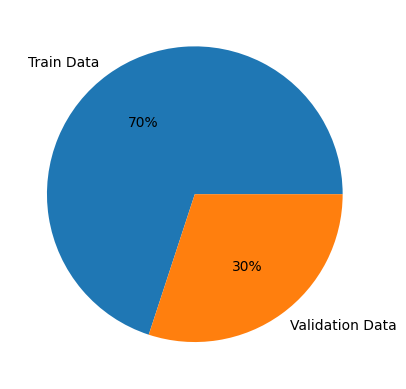

In [15]:
#pie diagram to see the splitted distribution
plt.pie([train_dataX.sum(),val_dataX.sum()],labels=["Train Data","Validation Data"],autopct="%1.f%%")

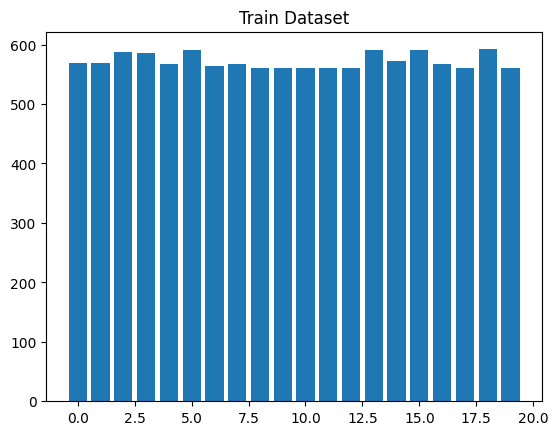

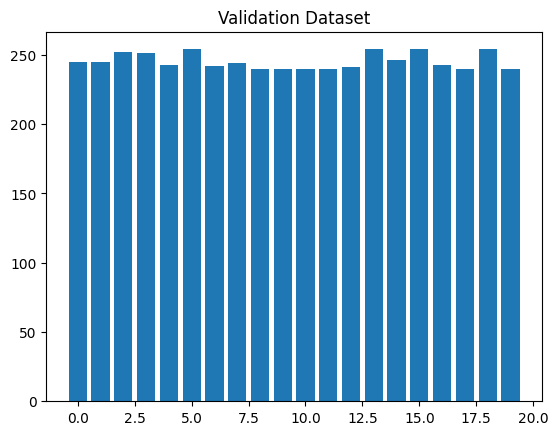

In [17]:
def calucationLen(path):
    destination_directory=final_source_datasets
    destination_directory1=destination_directory+path
    datay=np.zeros((len(classes)))
    datax=np.arange(0,len(classes),1)
    for i,class1 in enumerate(classes):
        class_source_dir=os.path.join(destination_directory1,class1)
        datay[i]=len(os.listdir(class_source_dir))
    # print()
    return [datax,datay]

#total image distribution from each fruit class in training
dataTrain=calucationLen("train")
fig, ax = plt.subplots()
ax.bar (dataTrain[0],dataTrain[1])
ax.set_title ('Train Dataset');

#total image distribution from each fruit class in validation
dataTrain=calucationLen("val")
fig, ax = plt.subplots()
ax.bar (dataTrain[0],dataTrain[1])
ax.set_title ('Validation Dataset');

## 4. Preparing dataset for training

In [20]:
#resize the images into size of 224 x 224
target_size=(224,224)
path_trainning=f"{final_source_datasets}train/"

#DEPRECATED
# generateTrain=ImageDataGenerator(rescale=1./255,
#                                 rotation_range=40,
#                                 fill_mode='nearest')

#using ImageDataGenerator for automatically label dataset by its directory name
#here we only normalize the image (the augmenting process already done before)

#training
generateTrain=ImageDataGenerator(rescale=1./255)

dataTrain=generateTrain.flow_from_directory(
    path_trainning,
    target_size=target_size,
    class_mode="categorical",
    batch_size=64,
    color_mode='rgb',
    shuffle=True)

#validation
path_validate=f"{final_source_datasets}val/"
generateValidate=ImageDataGenerator(rescale=1./255) #preprocessing images

dataValid=generateValidate.flow_from_directory(
    path_validate,
    target_size=target_size,
    class_mode="categorical",
     batch_size=64,
    color_mode='rgb',
    shuffle=True)


Found 11430 images belonging to 20 classes.
Found 4908 images belonging to 20 classes.


In [19]:
#sanity check to see corresponding labels
list(dataTrain.class_indices.keys())

['Alpukat',
 'Anggur',
 'Durian',
 'Jambu',
 'Jeruk',
 'Langsat',
 'Mangga',
 'Manggis',
 'Naga',
 'Nanas',
 'Nangka',
 'Pepaya',
 'Pir',
 'Pisang',
 'Rambutan',
 'Salak',
 'Sawo',
 'Semangka',
 'Srikaya',
 'Stroberi']

Text(0.5, 1.0, 'Example Train Data')

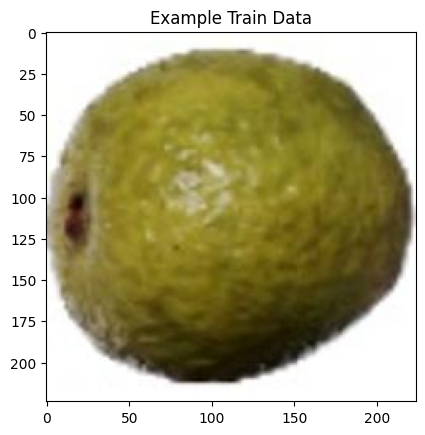

In [21]:
#randomly display an image from train set
iterator=iter(dataTrain)
image_batch, label_batch = next(iterator)
plt.imshow(image_batch[0])
plt.title("Example Train Data")

## 5. Train!
<h5>We use transfer learning for better accuracy and faster training. The pretrained model wes use for transfer learning is MobileNetV2</h5>

In [22]:
#define a callback function to stop the training loop after specific amount of accuracy

#@markdown Please input desired target accuracy

target_acc = 0.94 #@param {type:"number"}
class myCallback(tf.keras.callbacks.Callback):
 def on_epoch_end(self, epoch, logs={}):
  if(logs.get('accuracy')>target_acc):
    print(f"\nReached {target_acc}% accuracy so cancelling training!")
    self.model.stop_training = True

#instantiate the callback function defined
callbacks = myCallback()

<h2>CHOOSE EITHER ONE TO RUN!</h2>
<h5>please choose option (a) or (b)</h5>

### (a) With fine tuning
<h5>by unfreezing many layer within the pretrained model MobileNetV2</h5>

In [23]:
#to clear previous training session
tf.keras.backend.clear_session()

# Load the pre-trained MobileNetV2 model without the top layer
pretrained_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')


# Define the classifier function
def classifier():
    x = pretrained_model.layers[-6].output

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(20, activation="softmax", name="classification")(x) #TAMBAHANKU (AKU UBAH)
    return x

# Define and compile the model
def define_compile_model():
    classification_output = classifier()
    model = tf.keras.Model(inputs=pretrained_model.input, outputs=classification_output)

    #freeze few layers on top
    for layer in pretrained_model.layers[:-23]:
      layer.trainable = False

    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Create and summarize the model
model = define_compile_model()

pretrained_model.summary()
model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReL

### (b) Without fine tuning
<h5>Freezing all the layer beneath pretrained model MobileNetV2</h5>

In [31]:
#to clear previous training session
tf.keras.backend.clear_session()

# Load the pre-trained MobileNetV2 model without the top layer
pretrained_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

#freeze all of the layers of the pre-trained model
for layer in pretrained_model.layers:
    layer.trainable = False

# Define the classifier function
def classifier(inputs):
    x = pretrained_model(inputs)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(20, activation="softmax", name="classification")(x) #TAMBAHANKU (AKU UBAH)
    return x

# Define and compile the model
def define_compile_model():
    input = tf.keras.Input(shape=(224, 224, 3))
    classification_output = classifier(input)

    model = tf.keras.Model(inputs=input, outputs=classification_output)

    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Create and summarize the model
model = define_compile_model()

pretrained_model.summary()
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

## 6. Training loop
<h5>after running either one of above cell, let's execute this training loop cell</h5>

In [32]:
# #train the model

#@markdown Use callback?
enable_callback = True #@param {type:"boolean"}
#@markdown Define number of epoch
num_epoch = 1 #@param {type:"number"}

if enable_callback:
  history=model.fit(
      dataTrain,
      epochs=num_epoch,
      validation_data=dataValid,
      callbacks=[callbacks]
  )
else:
  history=model.fit(
      dataTrain,
      epochs=num_epoch,
      validation_data=dataValid
  )

179/179 [==============================] - 45s 229ms/step - loss: 1.2678 - accuracy: 0.8309 - val_loss: 0.1606 - val_accuracy: 0.9595


## 7. Save the model

In [40]:
# Save the model you just trained

#@markdown Input the model name to be saved
name_model = "fruiteasyV5" #@param {type:"string"}

#save to format .h5
model.save(f"{name_model}.h5")

#save to format .keras
model.save(f"{name_model}.keras")

#save to format tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
# Save the TFLite model to a file
with open(f'./{name_model}.tflite', 'wb') as f:
    f.write(tflite_model)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## 8. Download the model (OPTIONAL)

In [ ]:
# download the model
from google.colab import files
files.download(f"{name_model}.h5")
files.download(f"{name_model}.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 9. Evaluate recent trained model

In [35]:
model.history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

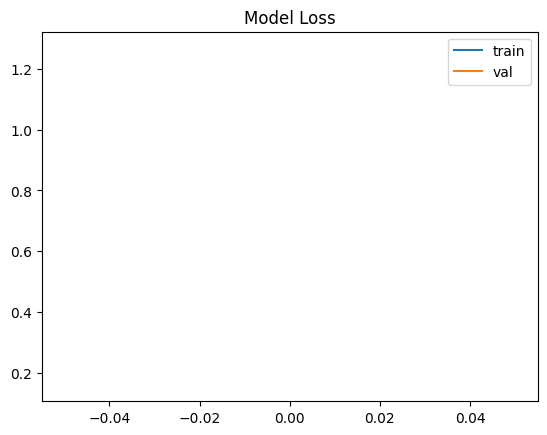

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.legend(['train',"val"])

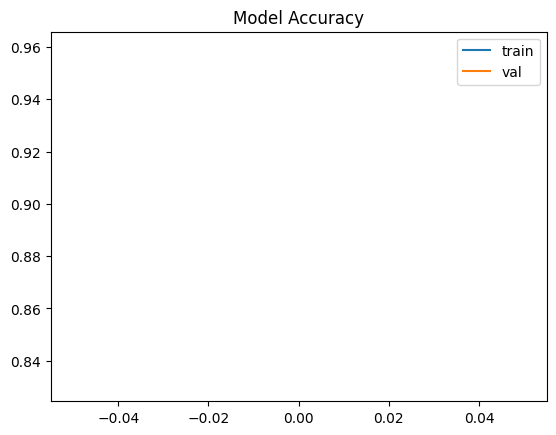

In [37]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.legend(['train',"val"])

In [41]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tabulate import tabulate
import seaborn as sns

#predict using recent model
test_predictions = model.predict(test_generator)

#print the classification report from test dataset using recent trained model prediction
print("Classification Report:\n", classification_report(true_labels, np.argmax(test_predictions, axis=-1)))


#plot the confusion matrix
confusion = confusion_matrix(true_labels, np.argmax(test_predictions, axis=-1))
#Define labels for the rows and columns
labels=list(test_generator.class_indices)
labels=[value.title() for value in labels]
columns=[''.join(char for char in input_String if char.isupper()) for input_String in labels]

# Create a table using tabulate
table = tabulate(confusion, headers=columns, showindex=labels, tablefmt="fancy_grid")

# Print the table
print(table)

26/26 [==============================] - 3s 132ms/step
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.76      0.86        37
           1       1.00      0.90      0.95        40
           2       1.00      0.97      0.99        40
           3       0.92      0.92      0.92        37
           4       1.00      1.00      1.00        40
           5       0.76      0.98      0.85        42
           6       0.86      1.00      0.93        38
           7       0.98      0.88      0.92        48
           8       0.98      1.00      0.99        40
           9       1.00      1.00      1.00        43
          10       0.89      1.00      0.94        41
          11       0.97      0.98      0.97        58
          12       0.88      0.95      0.92        40
          13       1.00      0.88      0.93        32
          14       1.00      1.00      1.00        44
          15       0.97      0.91      0.94        32
  

## 10. Predict image using recent trained model

Saving langsat.jpg to langsat.jpg
1/1 [==============================] - 2s 2s/step
0.9963743
9 Nanas
[[1.1543931e-08 5.7623410e-08 1.2172019e-07 1.0691288e-08 1.2019632e-06
  1.3202400e-03 9.8535744e-04 3.7562980e-08 8.6303970e-10 9.9637431e-01
  1.4064723e-06 5.4414238e-09 2.5607108e-06 6.5785905e-08 2.4175479e-09
  3.5260847e-08 1.3141677e-03 2.0159727e-09 2.0155960e-07 2.9071899e-07]]


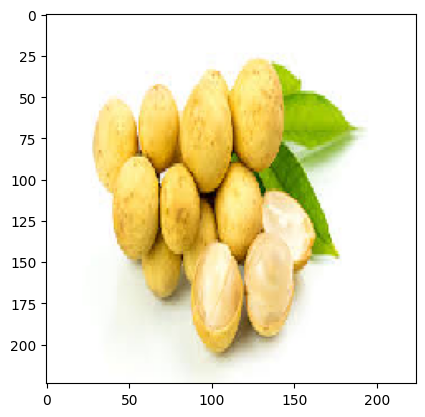

In [42]:
from tensorflow.keras.utils import load_img, img_to_array
from google.colab import files

reverse = {value: key for key, value in dataTrain.class_indices.items()}

uploaded=files.upload()

for fn in uploaded.keys():

  # predicting images
  path='/content/' + fn
  img=load_img(path, target_size=(224, 224))

  x=img_to_array(img)
  x /= 255
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])

  # classes = model.predict(images, batch_size=10)
  classes = model.predict(images)

  # print(classes[0])
  plt.imshow(img)
  print(np.max(classes))
  print(np.argmax(classes), reverse.get(np.argmax(classes)))
  print(classes)

# B. Use our pretrained model

## 1. Get the model

In [43]:
#@markdown ## Get the pretrained link ID from URL in <a href="https://github.com/yanuarcy/Fruiteasy/blob/ML/Model/our-pretrained.txt">Here</a>

#@markdown ___

#@markdown Format:

#@markdown ``https://drive.google.com/file/d/1bnnz-AsxpF74U6WouIYl70Nb-nrVr4Io/view?usp=sharing`` ❌

#@markdown ``1bnnz-AsxpF74U6WouIYl70Nb-nrVr4Io`` ✔️

#download pretrained model (fruiteasyV5.h5)
MODEL_URL = '1B7Jp0Wf-B1fLnvJmdDnVvbIcyd_f0WtG' #@param {type:"string"}
!gdown --id {MODEL_URL}

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1evWgDsT2Jn9yaYri9_HvsttF4zOoJJcN
From (redirected): https://drive.google.com/uc?id=1evWgDsT2Jn9yaYri9_HvsttF4zOoJJcN&confirm=t&uuid=f8b9447c-fe4c-44f1-b28d-b534245672a5
To: /content/fruiteasyV5.h5
100% 596M/596M [00:12<00:00, 48.1MB/s]


In [44]:
from tensorflow.keras.models import load_model

#@markdown Copy the model path from the files

pathModel="/content/fruiteasyV5.h5" #@param {type:"string"}
myModel=load_model(pathModel)
myModel.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

## 2. Get the test dataset

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle

# download dataset test (262-for-testV2)
# this test dataset is in English
# if you want to use the old version please change this link-id
!gdown --id '1-IwP2zJb0WK_d4DKeU5ZEEux4VTCucW9'

# extract the test dataset
destination_test_dir='./testcuy'
zip_test_dir='/content/262-for-testV2.zip'

with zipfile.ZipFile(zip_test_dir, 'r') as zip_ref:
    zip_ref.extractall(destination_test_dir)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    "/content/testcuy/262",
    target_size=(224,224),
    class_mode="categorical",
    batch_size=32,
    color_mode='rgb',
    shuffle=False)

#get true labels
true_labels = test_generator.classes
test_generator.class_indices

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1-IwP2zJb0WK_d4DKeU5ZEEux4VTCucW9
From (redirected): https://drive.google.com/uc?id=1-IwP2zJb0WK_d4DKeU5ZEEux4VTCucW9&confirm=t&uuid=66beece5-2773-4bc1-ac3c-bc1e653e098c
To: /content/262-for-testV2.zip
100% 58.2M/58.2M [00:01<00:00, 41.6MB/s]


## 3. Evaluate the downloaded model

In [45]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tabulate import tabulate
import seaborn as sns

#predict using downloaded pretrained model
test_predictions = myModel.predict(test_generator)

#print the classification report from test dataset using recent trained model prediction
print("Classification Report:\n", classification_report(true_labels, np.argmax(test_predictions, axis=-1)))


#plot the confusion matrix
confusion = confusion_matrix(true_labels, np.argmax(test_predictions, axis=-1))
#Define labels for the rows and columns
labels=list(test_generator.class_indices)
labels=[value.title() for value in labels]
columns=[''.join(char for char in input_String if char.isupper()) for input_String in labels]

# Create a table using tabulate
table = tabulate(confusion, headers=columns, showindex=labels, tablefmt="fancy_grid")

# Print the table
print(table)

26/26 [==============================] - 4s 128ms/step
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97        37
           1       1.00      1.00      1.00        40
           2       1.00      1.00      1.00        40
           3       1.00      1.00      1.00        37
           4       1.00      1.00      1.00        40
           5       0.89      0.98      0.93        42
           6       1.00      1.00      1.00        38
           7       1.00      0.96      0.98        48
           8       1.00      1.00      1.00        40
           9       1.00      1.00      1.00        43
          10       1.00      1.00      1.00        41
          11       0.98      1.00      0.99        58
          12       1.00      1.00      1.00        40
          13       1.00      1.00      1.00        32
          14       1.00      1.00      1.00        44
          15       1.00      0.91      0.95        32
  

## 4. Predict image using downloaded model

Saving dragonfruit.jpg to dragonfruit.jpg
1/1 [==============================] - 0s 22ms/step
1.0
8 Naga
[[2.12774175e-13 3.43770568e-11 7.94809531e-13 1.38493866e-17
  6.24345545e-18 2.65447785e-11 2.11582139e-15 4.73952509e-11
  1.00000000e+00 1.10028966e-15 2.93679907e-11 1.81817131e-16
  3.16150372e-13 3.43433344e-13 1.42262646e-15 1.36924714e-14
  2.00431441e-13 5.31545699e-17 1.11366049e-12 5.24089744e-14]]


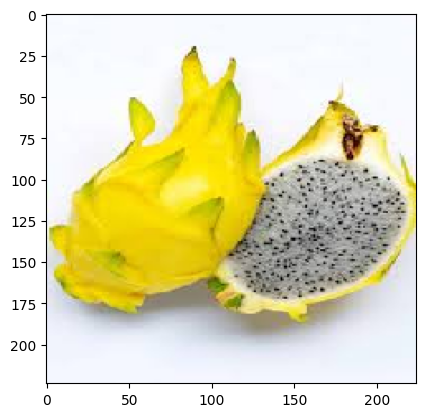

In [48]:
from tensorflow.keras.utils import load_img, img_to_array
from google.colab import files

reverse = {value: key for key, value in dataTrain.class_indices.items()}

uploaded=files.upload()

for fn in uploaded.keys():

  # predicting images
  path='/content/' + fn
  img=load_img(path, target_size=(224, 224))

  x=img_to_array(img)
  x /= 255
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])

  # classes = model.predict(images, batch_size=10)
  classes = myModel.predict(images)

  # print(classes[0])
  plt.imshow(img)
  print(np.max(classes))
  print(np.argmax(classes), reverse.get(np.argmax(classes)))
  print(classes)